In [1]:
from IPython.display import display,clear_output,HTML

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, matthews_corrcoef,\
                            precision_score, recall_score, roc_auc_score

from imblearn.over_sampling import SMOTE
import featuretools as ft
from sklearn.decomposition import PCA

Using TensorFlow backend.
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please impor

In [15]:
### Read HTML 
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df_html.shape)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)
count_columns=[col for col in df_html.columns if col.endswith('count')]
df_html['total_count']=df_html[count_columns].sum(axis=1)

href_columns=[col for col in df_html.columns if (('href_absolute' in col) | ('href_relative' in col) | ('href_page' in col))  ]
df_html['total_href']=df_html[href_columns].sum(axis=1)

total_img_src=[col for col in df_html.columns if 'img_src_' in col]
df_html['total_img_src']=df_html[total_img_src].sum(axis=1)


### Read JS 
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')
cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)
df_js.rename(columns={'Malicious':'Target'},inplace=True)
print("Shape of JS,DOM dataset:",df_js.shape)
df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)


### Read HTTP
df_http=pd.read_csv('HTTP.csv')
df_http.rename(columns={'Malicious':'Target'},inplace=True)
df_http.fillna(value=0,inplace=True)
cookies=[columns for columns in df_http.columns if 'number' in columns]
df_http.drop(cookies,axis=1,inplace=True)
df_http=df_http[df_http['domain']!=0]
df_http.sort_values(by='Target',inplace=True,ascending=False)
df_http.drop_duplicates(['domain'], keep='first',inplace=True)
df_http=df_http.sample(frac=1,random_state=0)
df_http.set_index(['domain'],drop=True,inplace=True)
print("Shape of HTTP dataset:",df_http.shape)



### Read URL
df_url=pd.read_csv('URL.csv')
df_url.fillna(value=0,inplace=True)
cookies=[columns for columns in df_url.columns if 'number' in columns]
df_url.drop(cookies,axis=1,inplace=True)
df_url.drop(['url_host','url_ip'],axis=1,inplace=True)
df_url=df_url[df_url['domain']!=0]
df_url.sort_values(by='Target',inplace=True,ascending=False)
df_url.drop_duplicates(['domain'], keep='first',inplace=True)
df_url=df_url.sample(frac=1,random_state=0)
print("Shape of URL dataset:",df_url.shape)
df_url.set_index('domain',inplace=True,drop=True)

df=pd.concat([df_js,df_html,df_http,df_url],axis=1,join='inner')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df['Target_z']=df[['Target','Target','Target','Target']].apply(max,axis=1)
df.drop(['Target','Target','Target','Target'],axis=1,inplace=True)
print("Shape of combined dataset:",df.shape)
df.rename(columns={'Target_z':'Target'},inplace=True)
df.Target.value_counts()

Shape of HTML dataset: (43491, 1461)
Shape of JS,DOM dataset: (43294, 401)
Shape of HTTP dataset: (45856, 672)


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (76,77,229,230,231,232,233,234,235,236,237,238,239,240,241,242,244,245,246,247,248,249,250,251,252,253,254,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,

Shape of URL dataset: (46771, 4194)
Shape of combined dataset: (39183, 6726)


0    34742
1     4441
Name: Target, dtype: int64

In [16]:
columns=['js_function_.push(',
 'a_count',
 'a_href_http',
 'a_href_https',
 'a_href_out_of_domain',
 'a_href_relative',
 'center_count',
 'form_action_http',
 'iframe_src_.html',
 'img_src_http',
 'link_href_out_of_domain',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'total_count',
 'total_href',
 'http_header_cache-control_set_max-age',
 'http_header_content-encoding_gzip',
 'http_header_server_apache',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'url_char_.',
 'url_char_f',
 'url_char_i',
 'url_char_l',
 'url_char_p',
 'url_char_w',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extensions',
 'url_length',
 'Target']

df['url_extension_endswith_.com']=df['url_extension_endswith_.com'].apply(lambda x: 1 if x==True else x)
df['url_extension_endswith_.com']=df['url_extension_endswith_.com'].astype(int)
print("features being used")
display(columns)
df_sel=df[columns].copy(deep=True)

features being used


['js_function_.push(',
 'a_count',
 'a_href_http',
 'a_href_https',
 'a_href_out_of_domain',
 'a_href_relative',
 'center_count',
 'form_action_http',
 'iframe_src_.html',
 'img_src_http',
 'link_href_out_of_domain',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'total_count',
 'total_href',
 'http_header_cache-control_set_max-age',
 'http_header_content-encoding_gzip',
 'http_header_server_apache',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'url_char_.',
 'url_char_f',
 'url_char_i',
 'url_char_l',
 'url_char_p',
 'url_char_w',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extensions',
 'url_length',
 'Target']

#### 1. No - Sampling

#### 70% for training, 30% for testing  
#### Split into Training and test set first. Split Training into training and validation. 
### We then remove malicious domains from training set and only include the non-malicious domains in the train-set. Thus, we cant perform over-sampling or undersampling
#### Standardize training and then scaled validation and testing


In [4]:
X_train, X_test = train_test_split(df_sel, test_size=0.3, random_state=0)

X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=0)
X_train = X_train[X_train.Target == 0]
X_train = X_train.drop(['Target'], axis=1) 
sc = StandardScaler()
scaled_X_train = sc.fit_transform(X_train)


X_val = X_val.drop(['Target'],axis=1)
scaled_X_val = sc.transform(X_val)

y_test = X_test['Target']
X_test = X_test.drop(['Target'], axis=1)
scaled_X_test = sc.transform(X_test)

#### a. L1 regularization of 10e-5
#### b. 4 encoding layers with 20,10,5 and 35 neurons respectively

In [5]:
input_dim = scaled_X_train.shape[1]
encoding_dim = 20
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

#### 200 epochs, batch_size=64, optimizer = ADAM , loss = mean_squared_error

In [6]:
nb_epoch = 500
batch_size = 64
autoencoder.compile(optimizer='adam',loss='mean_squared_error',metrics=['binary_accuracy'])
checkpointer = ModelCheckpoint(filepath="3_16_ns_model_70.h5",verbose=0,save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',histogram_freq=0,write_graph=True,write_images=True)
autoencoder.fit(scaled_X_train, scaled_X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=False,
                    validation_data=(scaled_X_val, scaled_X_val),
                    verbose=1)

Train on 19484 samples, validate on 5486 samples
Epoch 1/500
19484/19484 [==============================] - 1s 29us/step - loss: 0.9917 - binary_accuracy: 0.0000e+00 - val_loss: 1.1350 - val_binary_accuracy: 0.0000e+00
Epoch 2/500
19484/19484 [==============================] - 0s 18us/step - loss: 0.8530 - binary_accuracy: 0.0000e+00 - val_loss: 1.0139 - val_binary_accuracy: 0.0000e+00
Epoch 3/500
19484/19484 [==============================] - 0s 17us/step - loss: 0.7720 - binary_accuracy: 0.0000e+00 - val_loss: 0.9593 - val_binary_accuracy: 0.0000e+00
Epoch 4/500
19484/19484 [==============================] - 0s 17us/step - loss: 0.7234 - binary_accuracy: 0.0000e+00 - val_loss: 0.9022 - val_binary_accuracy: 0.0000e+00
Epoch 5/500
19484/19484 [==============================] - 0s 17us/step - loss: 0.6689 - binary_accuracy: 0.0000e+00 - val_loss: 0.8421 - val_binary_accuracy: 0.0000e+00
Epoch 6/500
19484/19484 [==============================] - 0s 17us/step - loss: 0.6296 - binary_accur

In [7]:
predictions = autoencoder.predict(scaled_X_test)
mse = np.mean(np.power(scaled_X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})

In [8]:
error_df.reconstruction_error.describe()

count    11755.000000
mean         0.646863
std          7.657220
min          0.078827
25%          0.221672
50%          0.331572
75%          0.515568
max        787.242411
Name: reconstruction_error, dtype: float64

In [11]:
# for i in np.arange(0,1,0.01):
#     threshold=i
#     y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
# #     pd.crosstab(error_df.true_class.values,np.array(y_pred))
#     print(i)
#     print("MCC on test set : " , matthews_corrcoef( error_df.true_class.values , np.array(y_pred) ) )

In [12]:
# for i in np.arange(0,1,0.01):
#     threshold=i
#     y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
# #     pd.crosstab(error_df.true_class.values,np.array(y_pred))
#     print(i)
#     print("MCC on test set : " , matthews_corrcoef( error_df.true_class.values , np.array(y_pred) ) )
# conf_matrix = confusion_matrix(error_df.true_class, y_pred)

threshold=0.66
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
print("Accuracy on test set : ", accuracy_score( error_df.true_class.values , np.array(y_pred) ) )
print("MCC on test set : " , matthews_corrcoef( error_df.true_class.values , np.array(y_pred) ) )
print("Precision : " , precision_score( error_df.true_class.values , np.array(y_pred) ) )
print("Recall : " , recall_score( error_df.true_class.values , np.array(y_pred) ) )
print("AUC : " , roc_auc_score( error_df.true_class.values , np.array(y_pred) ) )
pd.crosstab(error_df.true_class.values,np.array(y_pred))

Accuracy on test set :  0.8904296044236495
MCC on test set :  0.5573191045939374
Precision :  0.5129399585921325
Recall :  0.7406576980568012
AUC :  0.82516229435815


col_0,0,1
row_0,,
0,9476,941
1,347,991


### 2. Feature Transformation

In [24]:
df.reset_index(inplace=True)
# columns.remove('Target')
# columns.append('domain')
df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 2278 features
EntitySet scattered to workers in 3.914 seconds
Elapsed: 00:10 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [25]:
df.set_index(['domain'],drop=True,inplace=True)

In [26]:
# df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)
fs=fs.reindex(df.index.values)
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [27]:
feature_name=['url_length / total_count',
 'url_extensions / total_count',
 'url_char_w + url_char_z',
 'url_char_. / total_count',
 'url_char_. + url_char_w',
 'http_header_server_apache / total_count',
 'http_header_server_apache + url_char_w',
 'a_href_relative / total_href',
 'url_extensions / url_char_z',
 'url_extensions',
 'url_char_z / total_count',
 'url_char_y * url_extensions',
 'url_char_w / total_count',
 'url_char_w + url_extensions',
 'url_char_w * url_length',
 'url_char_w * url_extensions',
 'url_char_w',
 'url_char_p / total_count',
 'url_char_p + url_extensions',
 'url_char_l / total_count',
 'url_char_i / total_count',
 'url_char_f / total_count',
 'url_char_f + url_extensions',
 'url_char_f + url_char_w',
 'url_char_. + url_extensions',
 'url_char_. + url_char_z',
 'url_char_. + url_char_y',
 'url_char_. * url_char_w',
 'url_char_.',
 'http_header_via_1.1 + url_extensions',
 'http_header_vary_user-agent + url_extensions',
 'http_header_vary_user-agent + url_char_.',
 'http_header_server_apache + url_extensions',
 'http_header_content-encoding_gzip / url_char_.',
 'a_href_relative / a_count',
 'a_href_out_of_domain / total_href',
 'a_href_https / a_count','Target']
display(feature_name)

['url_length / total_count',
 'url_extensions / total_count',
 'url_char_w + url_char_z',
 'url_char_. / total_count',
 'url_char_. + url_char_w',
 'http_header_server_apache / total_count',
 'http_header_server_apache + url_char_w',
 'a_href_relative / total_href',
 'url_extensions / url_char_z',
 'url_extensions',
 'url_char_z / total_count',
 'url_char_y * url_extensions',
 'url_char_w / total_count',
 'url_char_w + url_extensions',
 'url_char_w * url_length',
 'url_char_w * url_extensions',
 'url_char_w',
 'url_char_p / total_count',
 'url_char_p + url_extensions',
 'url_char_l / total_count',
 'url_char_i / total_count',
 'url_char_f / total_count',
 'url_char_f + url_extensions',
 'url_char_f + url_char_w',
 'url_char_. + url_extensions',
 'url_char_. + url_char_z',
 'url_char_. + url_char_y',
 'url_char_. * url_char_w',
 'url_char_.',
 'http_header_via_1.1 + url_extensions',
 'http_header_vary_user-agent + url_extensions',
 'http_header_vary_user-agent + url_char_.',
 'http_head

In [28]:
fs=fs.reindex(df_sel.index.values)

#### 70% for training, 20% for testing  
#### Split into Training and test set first. Split Training into training and validation. 
### We then remove malicious domains from training set and only include the non-malicious domains in the train-set. Thus, we cant-perform over-sampling or undersampling
#### Standardize training and then scaled validation and testing


In [30]:
X_train, X_test = train_test_split(fs[feature_name], test_size=0.3, random_state=0)

X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=0)
X_train = X_train[X_train.Target == 0]
X_train = X_train.drop(['Target'], axis=1) 
sc = StandardScaler()
scaled_X_train = sc.fit_transform(X_train)


X_val = X_val.drop(['Target'],axis=1)
scaled_X_val = sc.transform(X_val)

y_test = X_test['Target']
X_test = X_test.drop(['Target'], axis=1)
scaled_X_test = sc.transform(X_test)
X_train = X_train.values
X_test = X_test.values

#### a. L1 regularization of 10e-5
#### b. 4 encoding layers with 20,10,5 and 35 neurons respectively

In [31]:
input_dim = X_train.shape[1]
encoding_dim = 20
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

#### 200 epochs, batch_size=64, optimizer = SDG , loss = mean_squared_error

In [32]:
nb_epoch = 200
batch_size = 64
autoencoder.compile(optimizer='SGD',loss='mean_squared_error',metrics=['binary_accuracy'])
checkpointer = ModelCheckpoint(filepath="3_16_ft_model.h5",verbose=0,save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',histogram_freq=0,write_graph=True,write_images=True)
autoencoder.fit(scaled_X_train, scaled_X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=False,
                    validation_data=(scaled_X_val, scaled_X_val),
                    verbose=1)

Train on 19484 samples, validate on 5486 samples
Epoch 1/200
19484/19484 [==============================] - 0s 20us/step - loss: 1.0303 - binary_accuracy: 0.0000e+00 - val_loss: 3.4818 - val_binary_accuracy: 0.0000e+00
Epoch 2/200
19484/19484 [==============================] - 0s 14us/step - loss: 1.0000 - binary_accuracy: 0.0000e+00 - val_loss: 3.2563 - val_binary_accuracy: 0.0000e+00
Epoch 3/200
19484/19484 [==============================] - 0s 14us/step - loss: 0.9683 - binary_accuracy: 0.0000e+00 - val_loss: 3.1030 - val_binary_accuracy: 0.0000e+00
Epoch 4/200
19484/19484 [==============================] - 0s 14us/step - loss: 0.9437 - binary_accuracy: 0.0000e+00 - val_loss: 3.0087 - val_binary_accuracy: 0.0000e+00
Epoch 5/200
19484/19484 [==============================] - 0s 14us/step - loss: 0.9177 - binary_accuracy: 0.0000e+00 - val_loss: 2.8999 - val_binary_accuracy: 0.0000e+00
Epoch 6/200
19484/19484 [==============================] - 0s 14us/step - loss: 0.8931 - binary_accur

In [33]:
predictions = autoencoder.predict(scaled_X_test)
mse = np.mean(np.power(scaled_X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})

In [34]:
error_df.reconstruction_error.describe()

count    11755.000000
mean         1.627487
std          8.450629
min          0.075800
25%          0.155913
50%          0.339640
75%          0.686731
max        360.333682
Name: reconstruction_error, dtype: float64

In [38]:
# threshold = error_df.reconstruction_error.describe()['25%']
threshold = 1.82
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
# conf_matrix = confusion_matrix(error_df.true_class, y_pred)

print("Accuracy on test set : ", accuracy_score( error_df.true_class.values , np.array(y_pred) ) )
print("MCC on test set : " , matthews_corrcoef( error_df.true_class.values , np.array(y_pred) ) )
print("Precision : " , precision_score( error_df.true_class.values , np.array(y_pred) ) )
print("Recall : " , recall_score( error_df.true_class.values , np.array(y_pred) ) )
print("AUC : " , roc_auc_score( error_df.true_class.values , np.array(y_pred) ) )
pd.crosstab(error_df.true_class.values,np.array(y_pred))

Accuracy on test set :  0.945044661846023
MCC on test set :  0.7212290763466314
Precision :  0.7737341772151899
Recall :  0.7309417040358744
AUC :  0.8517432912998801


col_0,0,1
row_0,,
0,10131,286
1,360,978


#### 3. PCA with Feature Transformation

In [39]:
df.reset_index(inplace=True)
# columns.remove('Target')
# columns.append('domain')
df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)
fs=fs.reindex(df.index.values)

Built 2278 features
EntitySet scattered to workers in 3.732 seconds
Elapsed: 00:09 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [40]:
X_train, X_test = train_test_split(fs, test_size=0.3, random_state=0)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=0)
X_train = X_train[X_train.Target == 0]

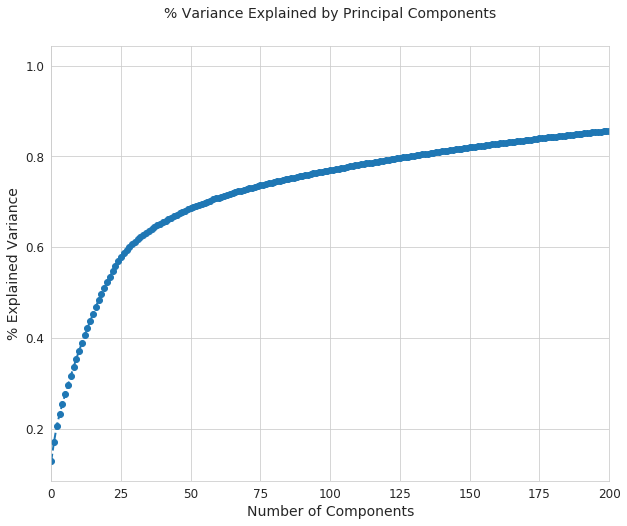

In [41]:
X=X_train.drop(['Target'] , axis=1)
y=X_train.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [42]:
pca=PCA(n_components=125,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 125 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 125 components is: 0.795417221715298


In [43]:
X_val = X_val.drop(['Target'],axis=1)
X_val_pca = pca.transform(X_val) 

y_test = X_test['Target']
X_test = X_test.drop(['Target'], axis=1)
X_test_pca = pca.transform(X_test)

In [44]:
input_dim = X_pca_21.shape[1]
encoding_dim = 20
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [45]:
nb_epoch = 200
batch_size = 64
autoencoder.compile(optimizer='SGD',loss='mean_squared_error',metrics=['binary_accuracy'])
checkpointer = ModelCheckpoint(filepath="3_16_pca_model.h5",verbose=0,save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',histogram_freq=0,write_graph=True,write_images=True)
autoencoder.fit(X_pca_21, X_pca_21,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=False,
                    validation_data=(X_val_pca, X_val_pca),
                    verbose=1)

Train on 19484 samples, validate on 5486 samples
Epoch 1/200
19484/19484 [==============================] - 0s 24us/step - loss: 1.0682 - binary_accuracy: 0.0000e+00 - val_loss: 23865568708.8997 - val_binary_accuracy: 0.0000e+00
Epoch 2/200
19484/19484 [==============================] - 0s 16us/step - loss: 1.0596 - binary_accuracy: 0.0000e+00 - val_loss: 23830623157.4714 - val_binary_accuracy: 0.0000e+00
Epoch 3/200
19484/19484 [==============================] - 0s 15us/step - loss: 1.0552 - binary_accuracy: 0.0000e+00 - val_loss: 23809764628.3456 - val_binary_accuracy: 0.0000e+00
Epoch 4/200
19484/19484 [==============================] - 0s 15us/step - loss: 1.0524 - binary_accuracy: 0.0000e+00 - val_loss: 23794712864.9916 - val_binary_accuracy: 0.0000e+00
Epoch 5/200
19484/19484 [==============================] - 0s 15us/step - loss: 1.0502 - binary_accuracy: 0.0000e+00 - val_loss: 23785437812.1881 - val_binary_accuracy: 0.0000e+00
Epoch 6/200
19484/19484 [==========================

In [46]:
predictions = autoencoder.predict(X_test_pca)
mse = np.mean(np.power(X_test_pca - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})

# threshold = error_df.reconstruction_error.describe()['25%']
threshold = 900
y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
# conf_matrix = confusion_matrix(error_df.true_class, y_pred)

print("Accuracy on test set : ", accuracy_score( error_df.true_class.values , np.array(y_pred) ) )
print("MCC on test set : " , matthews_corrcoef( error_df.true_class.values , np.array(y_pred) ) )
print("Precision : " , precision_score( error_df.true_class.values , np.array(y_pred) ) )
print("Recall : " , recall_score( error_df.true_class.values , np.array(y_pred) ) )
print("AUC : " , roc_auc_score( error_df.true_class.values , np.array(y_pred) ) )
pd.crosstab(error_df.true_class.values,np.array(y_pred))

Accuracy on test set :  0.845427477669077
MCC on test set :  0.5532059929427554
Precision :  0.4183986371379898
Recall :  0.9177877428998505
AUC :  0.8769604933180256


col_0,0,1
row_0,,
0,8710,1707
1,110,1228


In [47]:
### Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')